<a href="https://colab.research.google.com/github/ali7amie/Tianlai-M2-Internship-/blob/master/source_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To be merged
# 4.sophya, jskymap
# 5. the no detection problem
# 6. curves for single source, many, with and without haslam, jskymap (7 setup, tianlai, many observation strategies)
# 7. fitting
# 8. forecasts
# 9. transfer the matcher into the finder
!git clone https://github.com/ali7amie/Tianlai-M2-Internship-.git
%cd /content/Tianlai-M2-Internship-/


!pip install photutils
!pip install healpy
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
import scipy.ndimage as nd
import numpy.ma as ma
import pandas as pd

Cloning into 'Tianlai-M2-Internship-'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 318 (delta 85), reused 79 (delta 30), pack-reused 138
Receiving objects: 100% (318/318), 20.38 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/content/Tianlai-M2-Internship-
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 826 kB 30.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.7 MB 2.1 MB/s 


# Introduction

# Simulating sky maps

## Simulating with Python

These maps simulate observed images regardless of radio interferometry observation specificity. Each map results from adding white gaussian noise background to a set of unresolved sources distributed randomly. Assuming a gaussian beam (PSF), sources have perfect gaussian shapes. Maps are constructed as the following:

1. Build a gaussian prototype for sources with known size, amplitude in kelvin, standard deviation, and total flux density in jansky
2. Add the sources population to the noisy background

In [ ]:
import k2jansky

def create_gaussian_src(src_size,src_std,src_flux_jansky,freq):

    ''' 
    This function simulate a single source having gaussian shape, it take the size, the std, the flux in jansky, and the observed frequency. It gives a 2D NumPy array as a source 
    It use the function k2jansky located in the file k2jansky.py to convert the flux density from kelvin to jansky

    parameters:
    -------------
    src_size: int
                
    src_std: float

    src_flux_jansky: float

    freq: float
                          
       
    Return:
    -------  
    src: tuple (2D NumPy array, float, float)
         (a single source array, its flux in kelvin, its flux in jansky)
    '''
          
    # create a source with amplitude of 1 k
    x,y = np.meshgrid(np.linspace(-(src_size//2),src_size//2,src_size),np.linspace(-(src_size//2),src_size//2,src_size))
    mean_x=0
    mean_y=0
    src_1=np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))

    # Compute the flux density of the source having 1 K amplitude
    flux_kelvin_1=np.sum(src_1)

    # Converting this flux to jansky
    flux_jansky_1=k2jansky.k2jansky('freq',freq,16.5,1,flux_kelvin_1)

    
    # create sources having src_flux_jansky Jansky 
    src=src_flux_jansky * (1 / flux_jansky_1) * np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))

    # compute its flux density in kelvin
    flux_kelvin= np.sum(src)

    #compute its flux density in jansky
    flux_jansky=k2jansky.k2jansky('freq',freq,16.5,1,flux_kelvin)


    return (src, flux_kelvin, flux_jansky)

freq=1300*10**6

src=create_gaussian_src(5,1.1,3,freq)




    

...

In [ ]:


import create_gaussian_src
import convert_map_index
import pixel2world



def create_map(map_size,src_number,src_size,src_std,src_flux_jansky,noise_std,freq,map_resolution,projection_center):

    ''' This function simulate a gnomonic projection of a sky map with a given field of view and center of projection center. I take many parameters and gives the map and a detailed dataframe about its components  
    It use Pandas, the function create_gaussian_src from the file create_gaussian_src.py, the function convert_upper_to_center from the file convert_map_index.py, and the function pixel2world from the file pixel2world.py
    parameters:
    -------------
    map_size: int 
              (lenght of a side)
                
    src_number: int

    src_flux_jansky: float 
                     (all the sources have the same flux)

    noise_std: float 
               (the std of white gaussian noise)

    freq: float

    map_resolution: int 
                    (given in arcminutes, for instance 18)

    projection_center: tuple 
                       (latitude [deg], longitude [deg]) ????????
                          
       
    Return:
    -------  
    simulation: tuple (2D NumPy array, dataframe)
         (square map, detailed components'dataframe)
    '''
    #create empty map
    rectmap=np.zeros((map_size,map_size))

    #create a gaussian source with the entered parameters
    src=create_gaussian_src.create_gaussian_src(src_size,src_std,src_flux_jansky,freq)

    #turn on src_number pixels randomely, to limit the boundary effect source are generated far from boudndaries 
    horizontal_coor=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number)
    vertical_coor=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number) #generate random position, note that x and y here represent a matrix like coordinate, so the number of column or absice is y, the number of row or ordonnée is x
    
    # assign to each lightened pixel a gaussian source
    for i in range(0,len(vertical_coor)):
            rectmap[vertical_coor[i]-(src_size//2):vertical_coor[i]+((src_size//2)+1),horizontal_coor[i]-(src_size//2):horizontal_coor[i]+((src_size//2)+1)]=src[0]
    
    #add a map of gaussian noise
    noise =  make_noise_image((map_size,map_size), distribution='gaussian', mean=0,stddev=noise_std)
    rectmap=rectmap+noise

    #create a dataframe containing catalog of simulated sources

      #compute coordinates if the center of images is (0,0)
    coor_center=convert_map_index.convert_upper_to_center( [ vertical_coor,horizontal_coor ] , np.shape(rectmap)[0],len(vertical_coor) )[4]
  
      #compute world coordinate
    world_coor=pixel2world.pixel2world(projection_center,map_resolution,coor_center)

      # setup the dataframe
    data=np.column_stack((world_coor[:,0],world_coor[:,1],vertical_coor,horizontal_coor,coor_center[:,1],coor_center[:,0],src[1]*np.ones(len(vertical_coor)),src[2]*np.ones(len(vertical_coor))))
    simulation_dataframe=pd.DataFrame(data,columns=['ra[deg]','dec[deg]','vertical coor[pixel]','horizontal coor[pixel]','vertical center','horizontal center','flux [K]','flux[Jy]'])

      # sort the dataframe in decreasing declination, this is useful for catalogs matching
    sorter=np.flip(np.argsort(simulation_dataframe['dec[deg]']))
    sorted_simulation_dataframe = simulation_dataframe.iloc[sorter] 

    return (rectmap,sorted_simulation_dataframe)

simulation=create_map(50,10,5,1.1,1,0.001,freq,18,(180,90)) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead


## JSKyMap software's Simulations

These maps simulate the transit observation procedure of radio interferometry. JSkyMap simulates all visibilities of the interferometer, defined as the mean of the correlation of two dish feeds, and uses them to compute full sky maps in spherical geometry. 

JSkyMap is written in C++ and uses the SOPHYA class library.

1. Install SOPHYA
2. Install JSkyMap

We will use Shell to execute JSkyMap commands

**INCOMPLETE**


In [ ]:
set JEXE=$JSKYBASE/Objs
set NCPDECPOINT=90,88,86,84
set FREQ=1300
set SETUPF = seven_setup.d
set NSIDE = 256
set LMAX = 700
set BEAMFILE = beam_autoon_{$FREQ}_4dec_double.ppf
set AINV = inv_autoon_{$FREQ}_4dec_double.ppf
set INMAP = haslam1300eq.fits 
set SIGMAELL = 450
set SRCFILE = srctxt_{$FLUX}jansky_iteration{$ITERATION}.txt
set VISFILE = vis_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.ppf
set OUTMAPF = map_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits
set RECALMFILE=map_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits
set FILTMAPFILE=filtmap_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits


$JEXE/map2vis -sharp -setup $SETUPF -pdec $NCPDECPOINT -freq $FREQ -healpix $NSIDE -lmax $LMAX -nthreads 10,16 -mxprod blas,4 -ngb -in $INMAP -src $SRCFILE -out $VISFILE 
$JEXE/p4src2vis -setup $SETUPF -src $SRCFILE -freq $FREQ -noise $NOISE -ram 1 -healpix $NSIDE -pdec $NCPDECPOINT -ngb -out $VISFILE 
$JEXE/vis2map -freq $FREQ -lmax $LMAX -noise $NOISE -rdbeam $BEAMFILE -rdainv $AINV -healpix $NSIDE -psithr 0.02,0.001 -nthreads 8,6 -ngb -prt 2 -sharp -mxprod blas,4 $SETUPF $VISFILE visarr_ $NCPDECPOINT $OUTMAPF  
$JEXE/filt2map -lmax $LMAX -healpix $NSIDE -gaussfilt $SIGMAELL -fmlow 1 $RECALMFILE $FILTMAPFILE 

SyntaxError: ignored

# Source finder description

### Input map

#### Maps made with JSKyMap

The final output of JSkyMap consists of a full sky map in spherical geometry pixelated according to HEALPix and loaded in a FITS file. This step of the source finder uses the HealPy package to perform the following task:
1. read the fits file 
2. load the data in NumPy arrays, where a temperature is assigned to each HEALPix pixel
3. crop a gnomonic projection of the observed zone (North Celestial Pole). Thus, the new projection consists of a new NumPy array that assigns a temperature to new square pixels. **The size of the observation pixel, the HEALPix pixel size, and the gnomonic square pixel size are tightly related**








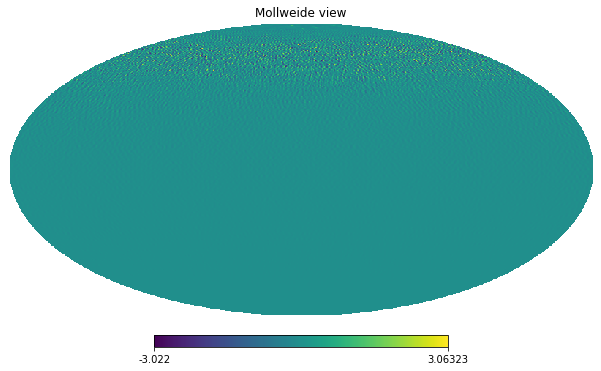

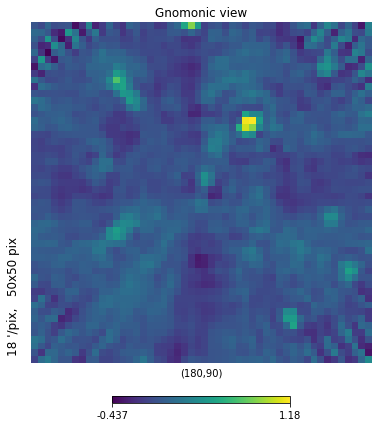

In [ ]:

def fits2map(fits_filename,map_size, map_resolution, projection_center):

  ''' This function take a fits file, convert it into full spherical sky map,
   and return a gnomonic projection around a given point 

   fits_filename : str
                   FITS file name

   map_size : int
              the side length in pixels of of the square gnomonic map

   map_resolution : int
                    map resolution in arcminutes

   projection_center : tuple
                       (longitude, latitude) the coordinate of the projection center in degrees '''

  #convert the fits file into healpix pixelized full sky map
  full_map = hp.read_map(fits_filename,dtype = None)

  #display a mollweide projection
  spherical_map = hp.mollview(full_map,return_projected_map = True)#, no_plot = True)

  #crop a gnomonic view at NCP
  rectmap = hp.gnomview(full_map,rot=[projection_center[0],projection_center[1]],reso = map_resolution,xsize = map_size,ysize = map_size,return_projected_map = True)#, no_plot = True)
  

  return (rectmap,[0,0])

JS_simulation = fits2map("filtmap_ncp_autoon_0.001_1300_0.075_0_4dec.fits",50,18,(180,90))



#### Maps made with python

Here the input map already consists of a square map and there is no additional task to do. Its size and resolution mimic gnomonic projections of spherical maps.

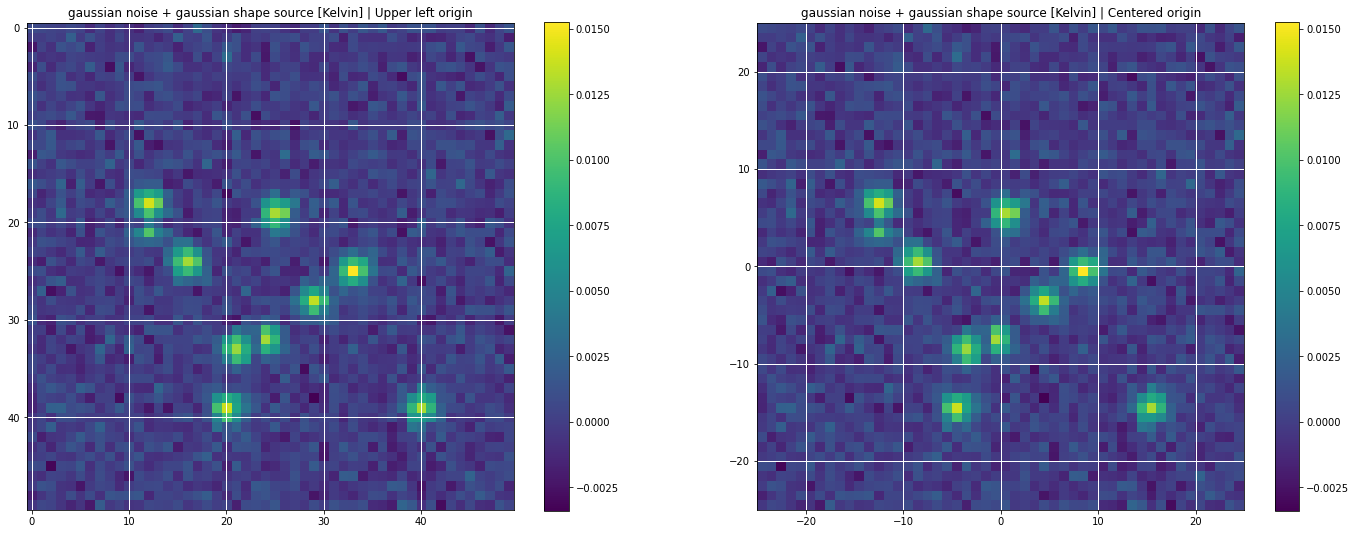

,ra[deg],dec[deg],vertical coor[pixel],horizontal coor[pixel],vertical center,horizontal center,flux [K],flux[Jy]
0,95.194429,88.343657,19.0,25.0,5.5,0.5,0.098595,1.0
5,217.874984,88.290245,28.0,29.0,-3.5,4.5,0.098595,1.0
1,273.814075,87.746169,32.0,24.0,-7.5,-0.5,0.098595,1.0
6,183.366461,87.447282,25.0,33.0,-0.5,8.5,0.098595,1.0
3,3.366461,87.447282,24.0,16.0,0.5,-8.5,0.098595,1.0
9,292.380135,87.244410,33.0,21.0,-8.5,-3.5,0.098595,1.0
2,19.798876,86.020811,20.0,12.0,4.5,-12.5,0.098595,1.0
7,27.474432,85.780941,18.0,12.0,6.5,-12.5,0.098595,1.0
8,287.241459,85.454890,39.0,20.0,-14.5,-4.5,0.098595,1.0
4,223.090848,83.658526,39.0,40.0,-14.5,15.5,0.098595,1.0


In [ ]:

projection_center=(180,90)
map_resolution=18


rectmap=simulation[0]

plt.figure(figsize=[24, 9])

plt.subplot(121)
plt.imshow(rectmap)
plt.colorbar()
plt.title('gaussian noise + gaussian shape source [Kelvin] | Upper left origin')
plt.grid(color='w', linestyle='-', linewidth=1)

plt.subplot(122)
plt.imshow(rectmap,extent=(-np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2, -np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2))
plt.colorbar()
plt.grid(color='w', linestyle='-', linewidth=1)
plt.title('gaussian noise + gaussian shape source [Kelvin] | Centered origin')

plt.show()

simulation[1]

### Global background estimation

In [ ]:
def rectmap_statistics(rectmap):
    return(np.median(rectmap),np.std(rectmap))

global_stat=rectmap_statistics(rectmap)    
global_stat

(0.00011761905571017593, 0.0018488831731805965)

### Building a set of detection kernels

Creating the kernels and detection tools before execute the detection criteria
<br>
we used three kernels : cental, intermediate, and peripheric <br> (**could be made with open CV???**)

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 1)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


def create_kernels(detection_kernels_size):


    ''' This function take the size of kernels and give the kernels 

    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''


    #create the central kernel
    normalization1 = 1/detection_kernels_size[0]**2
    central_kernel = normalization1 * np.ones((detection_kernels_size[0],detection_kernels_size[0]))

    #create intermediate kernel
    normalization2 = 1/(detection_kernels_size[1]**2 - detection_kernels_size[0]**2)
    intermediate_kernel = normalization2 * np.pad(0*central_kernel,int((detection_kernels_size[1]-detection_kernels_size[0])/2),pad_with)

    #create peripherical kernel
    normalization3 = 1/(detection_kernels_size[2]**2 - detection_kernels_size[1]**2)
    peripherical_kernel = normalization3 * np.pad(0*intermediate_kernel,int((detection_kernels_size[2]-detection_kernels_size[1])/2),pad_with)

    
    
    
    return (central_kernel, intermediate_kernel, peripherical_kernel)
    
detection_kernels_size=(3,5,7)
kernels=create_kernels(detection_kernels_size)




### Create convolution maps

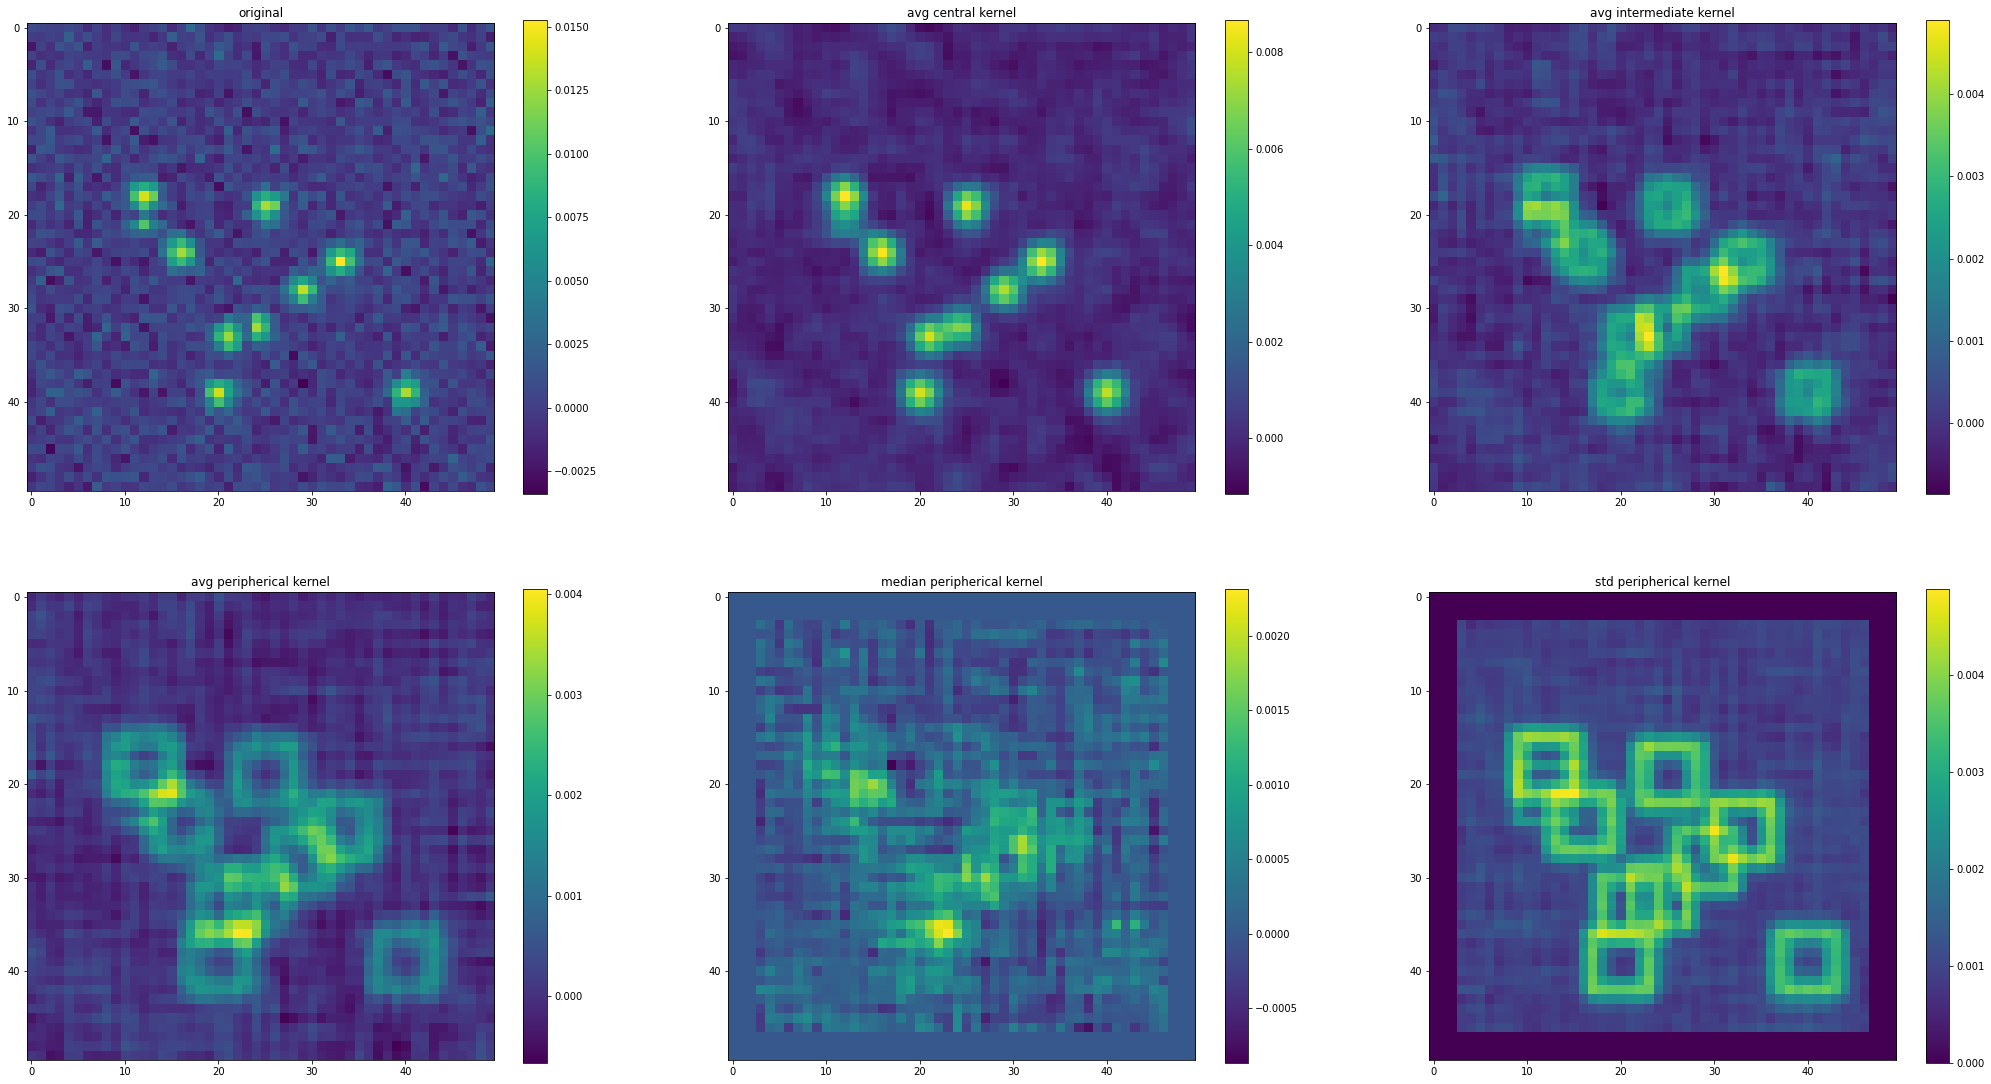

In [ ]:
def create_conv_maps(kernels,detection_kernels_size,rectmap):


    ''' This function take three kernels and give convolution maps 

    kernels: tuple
             (central kernel (ndarray), intermediate kernel (ndarray), peripherical kernel (ndarray))
             
    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''

    central_kernel_map=nd.convolve(rectmap,kernels[0])
    intermediate_kernel_map=nd.convolve(rectmap,kernels[1])
    peripherical_kernel_map=nd.convolve(rectmap,kernels[2])


    # an additional kernel wich compute median and std maps (local background)   
    peripheric_median_map=np.zeros_like(rectmap)
    peripheric_std_map = np.zeros_like(rectmap)
    mask=np.array(kernels[2]==0)
    for i in range(int(detection_kernels_size[2]/2),rectmap.shape[0]-int(detection_kernels_size[2]/2)):
        for j in range(int(detection_kernels_size[2]/2),rectmap.shape[1]-int(detection_kernels_size[2]/2)):
            if (detection_kernels_size[2]/2).is_integer()==False:
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+(int(detection_kernels_size[2]/2)+1),j-int(detection_kernels_size[2]/2):j+(int(detection_kernels_size[2]/2)+1)]
                    
            else:
                    
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+int(detection_kernels_size[2]/2),j-int(detection_kernels_size[2]/2):j+int(detection_kernels_size[2]/2)]
                    
            masked_kernel=ma.masked_array(kernel,mask)
            peripheric_std_map[i][j]=np.ma.std(masked_kernel)
            peripheric_median_map[i][j]=np.ma.median(masked_kernel)

    return (central_kernel_map,intermediate_kernel_map,peripherical_kernel_map,peripheric_median_map,peripheric_std_map)       

conv_maps=create_conv_maps(kernels,detection_kernels_size,rectmap)

plt.figure(figsize=[35.6, 19.2])
title=['avg central kernel','avg intermediate kernel','avg peripherical kernel','median peripherical kernel','std peripherical kernel']

plt.subplot(231)
plt.imshow(rectmap)
plt.title('original') 
plt.colorbar() 

for i in range(0,len(conv_maps)):
   
    plt.subplot(232+i)
    plt.imshow(conv_maps[i])
    plt.title(title[i])
    plt.colorbar()

plt.show()


### Apply the detection criteria

Now we have the detection kernels <br> we conduct a detection criteria: a pixels belong to a potential source if: avg(central_kernel)>local_bg+n*local_std

This step output a list of pixels that are said to belong to potential sources. We should sort these pixels into sources. We sort pixels by their S/N ratio and then merge them hierarchically. We set a threshold of temperature, and assign other pixels inside an aperture to the targeted one.

1. set the detection criteria
2. applying it to each pixel on the map
3. we recieve a list of pixel that belong to sources
4. sort pixels by their S/N ratio as the begin of hierarchical merging


In [ ]:
def detection(conv_maps,n):

     ''' This function take convolution maps, manipulate them within detection criteria, 
     and return list of pixels that belong to potential sources and their amplitude. It is sorted by the S/N ratio

    conv_maps: tuple
               (avg central map (ndarray), avg intermediate map (ndarray), avg peripherical map (ndarray), median peripherical map (ndarray), std peripherical map (ndarray))
             
    n: int
       The detection threshold '''


     threshold = conv_maps[3] + n * global_stat[1] 
     first_condition = conv_maps[0] >= threshold 
     detected_src_coor_upper_pixcorner = np.where( first_condition )  #this list of coordinate are in the upper system (vertical from top, horizontal from left) and each pixel is localized by its corner
     detected_src_coor_center=convert_map_index.convert_upper_to_center([detected_src_coor_upper_pixcorner[0],detected_src_coor_upper_pixcorner[1]],np.shape(conv_maps[0])[0],len(detected_src_coor_upper_pixcorner[1]))[4]

     signal = rectmap[detected_src_coor_upper_pixcorner]
     local_bg = conv_maps[3][detected_src_coor_upper_pixcorner] 
     local_bg_std = conv_maps[4][detected_src_coor_upper_pixcorner] 
     signal_to_noise = signal/local_bg_std
     raw_detected_pix=np.column_stack((detected_src_coor_upper_pixcorner[0],detected_src_coor_upper_pixcorner[1],detected_src_coor_center[:,1],detected_src_coor_center[:,0],signal,local_bg,local_bg_std,signal_to_noise,np.zeros(len(signal))))
     raw_detection = pd.DataFrame(raw_detected_pix,columns=['vertical coor','horizontal coor','vertical center','horizontal center','Amplitude [K]','Local median','Local std','S/N','Flag'])
     sorter=np.flip(np.argsort(raw_detection['S/N']))
     sorted_raw_detection = raw_detection.iloc[sorter]
     return sorted_raw_detection

sorted_raw_detection = detection(conv_maps,2)
sorted_raw_detection







,vertical coor,horizontal coor,vertical center,horizontal center,Amplitude [K],Local median,Local std,S/N,Flag
68,39.0,20.0,-14.5,-4.5,0.013749,0.000136,0.000774,17.764776,0.0
13,19.0,25.0,5.5,0.5,0.012855,-0.000009,0.000764,16.825893,0.0
71,39.0,40.0,-14.5,15.5,0.012812,0.000076,0.000976,13.123084,0.0
14,19.0,26.0,5.5,1.5,0.011330,-0.000021,0.000979,11.573639,0.0
74,40.0,20.0,-15.5,-4.5,0.009650,0.000496,0.000844,11.430140,0.0
...,...,...,...,...,...,...,...,...,...
35,26.0,32.0,-1.5,7.5,0.006212,0.001321,0.003244,1.914689,0.0
16,20.0,12.0,4.5,-12.5,0.004145,0.000503,0.002670,1.552395,0.0
56,33.0,23.0,-8.5,-1.5,0.003048,0.000710,0.002483,1.227800,0.0
50,32.0,23.0,-7.5,-1.5,0.002379,0.000776,0.002369,1.004137,0.0


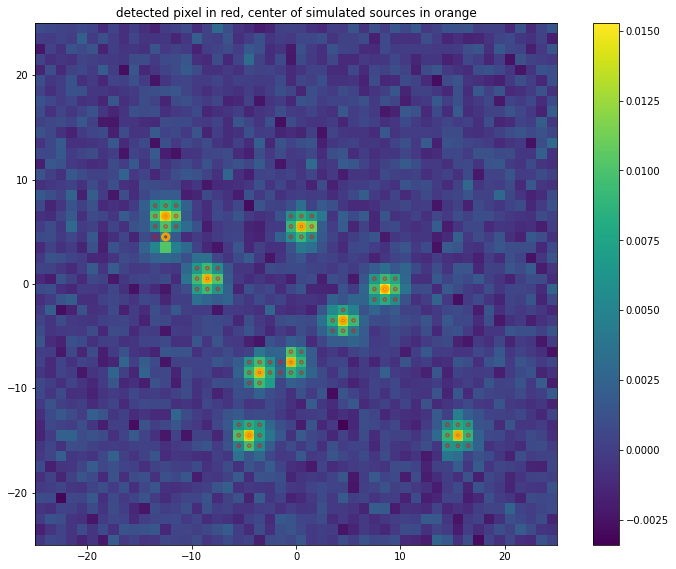

In [ ]:
from photutils.aperture import CircularAperture

    
detected_pixels_center = CircularAperture(np.transpose((sorted_raw_detection['horizontal center'],sorted_raw_detection['vertical center'])), r=0.15)
simulated_src_center=CircularAperture(np.transpose((simulation[1]['horizontal center'],simulation[1]['vertical center'])), r=0.3)


    
plt.figure(figsize=[12.8, 9.6])

plt.title('detected pixel in red, center of simulated sources in orange')
plt.imshow(rectmap,extent=(-np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2, -np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2))
plt.colorbar()    
detected_pixels_center.plot(color='red', lw=1.5, alpha=0.5)
simulated_src_center.plot(color='orange', lw=3, alpha=0.9)

plt.show(block=False)

### Hierarchical merging

1. hierarchical merging
2. this step output a list, where each item group indexes of pixels that form the same source

In [ ]:
def merging(aperture,sorted_raw_detection):


    ''' This function take an aperture, and the dataframe of all detections'pixels and give a list where each element represent itself a list of indexes contributing to a single sources

    parameters:
    -------------
    aperture: tuple (float,float)
               (3,2.5)  
    sorted_raw_detection: dataframe 
                          all pixels verifying detection criteria sorted by their decreasing S/N ratio
       
    Return:
    -------  
    all_agglomerations_index: list
                              a list where each element represent itself a list of indexes contributing to a single sources
    '''
        

    id=sorted_raw_detection.index
    all_agglomerations_index=[]
    for i in id:
        if sorted_raw_detection['Flag'][i]==0:
            pixels_index_in_each_src=[]
            for j in id:
                c1=sorted_raw_detection['vertical coor'][j] >= sorted_raw_detection['vertical coor'][i] - aperture[0] 
                c2=sorted_raw_detection['vertical coor'][j] <= sorted_raw_detection['vertical coor'][i] + aperture[0] 
                c3=sorted_raw_detection['horizontal coor'][j] >= sorted_raw_detection['horizontal coor'][i] - aperture[0]
                c4=sorted_raw_detection['horizontal coor'][j] <= sorted_raw_detection['horizontal coor'][i] + aperture[0]
                if (c1 and c2 and c3 and c4):
                    offset = np.sqrt( ( sorted_raw_detection['vertical coor'][i] - sorted_raw_detection['vertical coor'][j] )**2 + ( sorted_raw_detection['horizontal coor'][i] - sorted_raw_detection['horizontal coor'][j] )**2 )
                    if offset<=aperture[1]:
                        pixels_index_in_each_src.append(j)
                        sorted_raw_detection['Flag'][j]=1
            all_agglomerations_index.append(pixels_index_in_each_src)
    return all_agglomerations_index

aperture=(3,3)        
all_agglomerations_index=merging(aperture,sorted_raw_detection)
all_agglomerations_index


[[68, 74, 69, 67, 62, 63, 75, 61, 73],
 [13, 14, 18, 12, 7, 19, 8, 17, 6],
 [71, 72, 70, 65, 66, 77, 76, 78, 64],
 [34, 28, 33, 27, 37, 26, 36, 32, 35],
 [24, 30, 25, 21, 29, 31, 22, 23, 20],
 [10, 1, 4, 2, 0, 5, 9, 3, 11, 16, 15],
 [53, 47, 59, 54, 55, 48, 60, 49, 56],
 [40, 43, 39, 38, 41, 42, 44],
 [51, 52, 55, 45, 48, 46, 49, 58, 57, 56, 50]]

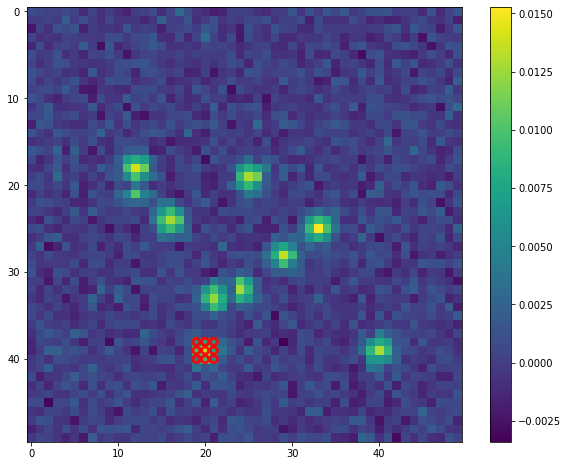

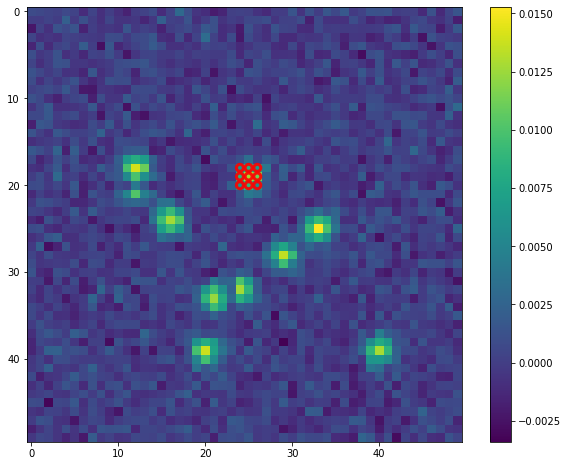

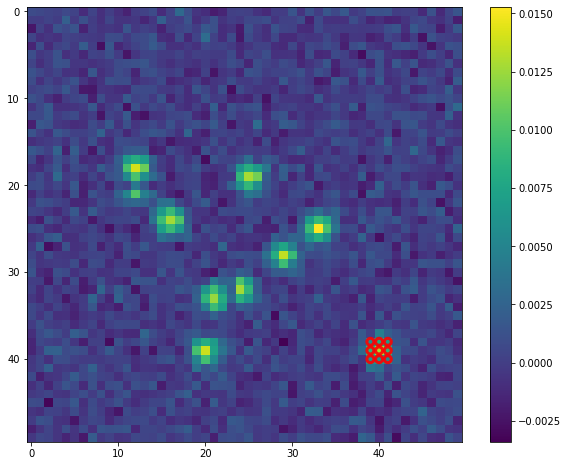

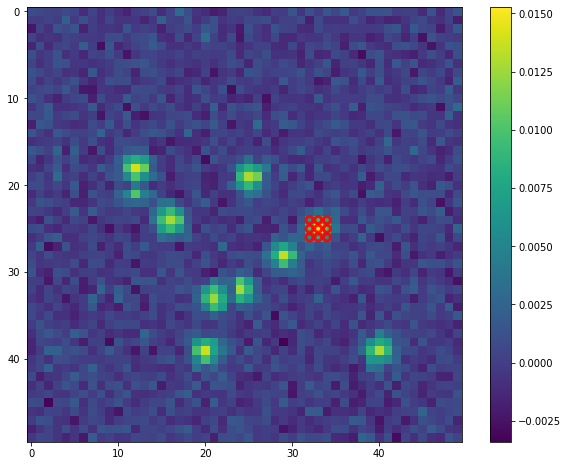

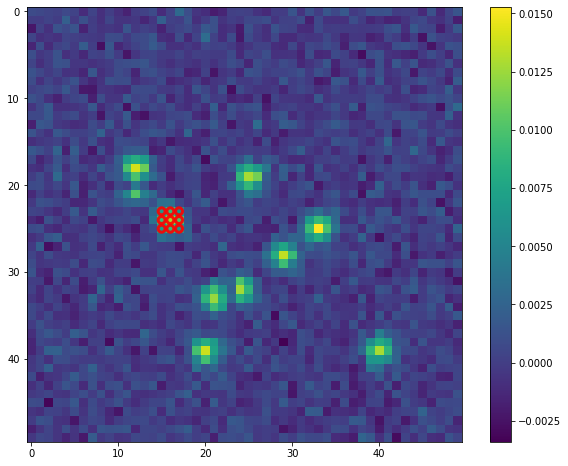

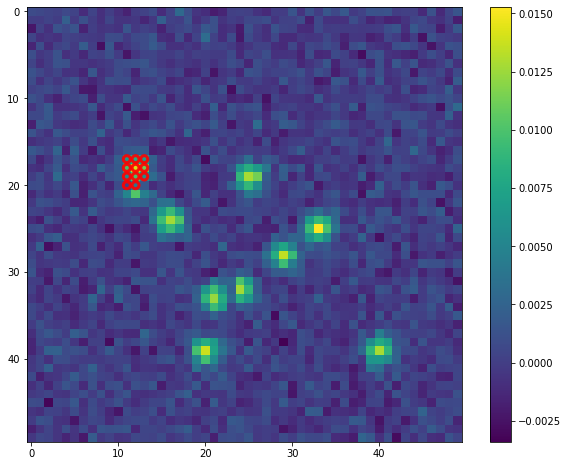

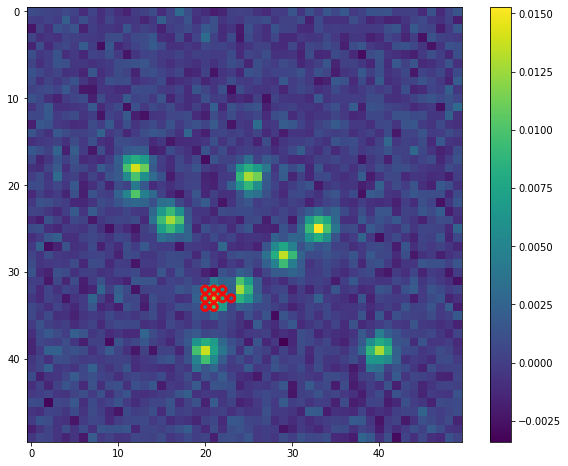

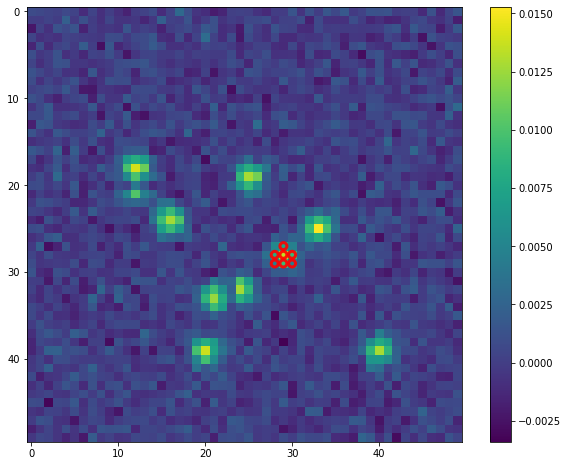

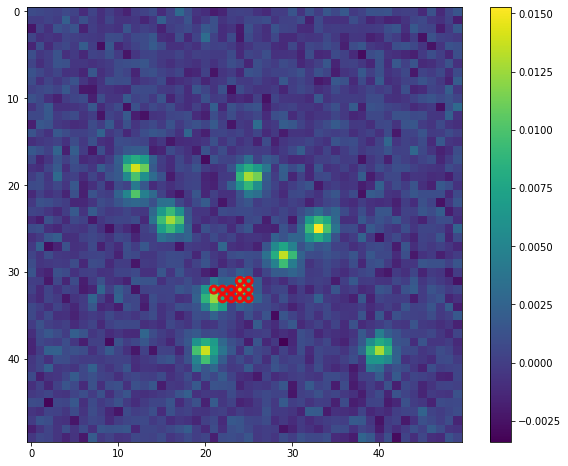

In [ ]:

for k in range(0,len(all_agglomerations_index)):
    sources_upper=CircularAperture(np.transpose((sorted_raw_detection['horizontal coor'][all_agglomerations_index[k]],sorted_raw_detection['vertical coor'][all_agglomerations_index[k]])), r=0.4)

    plt.figure(figsize=[10, 8])
    plt.imshow(rectmap)
    plt.colorbar()    
    sources_upper.plot(color='red', lw=3, alpha=0.9)
    plt.show(block=False)
   


### Compute barycenters

In [ ]:
def compute_barycenters(sorted_raw_detection,all_agglomerations_index):

    ''' This function take the main dataframe and the list of pixels goups, and compute a list of barycenters 

    parameters:
    -------------
    sorted_raw_detection: dataframe 
                          all pixels verifying detection criteria sorted by their decreasing S/N ratio
       
    all_agglomerations_index: list
                              a list where each element represent itself a list of indexes contributing to a single sources

    Return:
    -------   
    barycenter_list:   tuples list     (2 x source number) 
                       each line present (vertical coor, horizontal coor)                 
    '''
    horizontal_barycenter_list=[]
    vertical_barycenter_list=[]
    for i in range(0,len(all_agglomerations_index)):
        deno = np.sum(sorted_raw_detection['Amplitude [K]'][all_agglomerations_index[i]])
        horizontal_barycenter = np.sum( sorted_raw_detection['horizontal coor'][all_agglomerations_index[i]] * sorted_raw_detection['Amplitude [K]'][all_agglomerations_index[i]] ) / deno
        vertical_barycenter = np.sum( sorted_raw_detection['vertical coor'][all_agglomerations_index[i]] * sorted_raw_detection['Amplitude [K]'][all_agglomerations_index[i]] ) / deno
        horizontal_barycenter_list.append(horizontal_barycenter)
        vertical_barycenter_list.append(vertical_barycenter)

    return np.transpose((np.round(vertical_barycenter_list,0).astype(int),np.round(horizontal_barycenter_list,0).astype(int) ))

barycenter_list = compute_barycenters(sorted_raw_detection,all_agglomerations_index)
barycenter_list





array([[39, 20],
       [19, 25],
       [39, 40],
       [25, 33],
       [24, 16],
       [18, 12],
       [33, 21],
       [28, 29],
       [32, 24]])

### Computing fluxes

In [ ]:
def compute_flux(detection_kernels_size, barycenter_list, conv_maps, freq):

    ''' This function take the the convolution maps, the kernels size, the list of barycenters and the frequency, to compute a list of fluxes density in Kelvin and in Jansky
    
    parameters:
    -------------

    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel)

    barycenter_list:   tuples list     (2 x source number) 
                       each line present (vertical coor, horizontal coor) 
                       
    conv_maps: tuple
              (avg central map (ndarray), avg intermediate map (ndarray), avg peripherical map (ndarray), median peripherical map (ndarray), std peripherical map (ndarray))
                                      
    freq: float
          the frequency of signal in hertz


    Return:
    -------   
    flux_list:   tuples    (list,list) 
                       list of fluxes in kelvin and in Jansky                
    '''
    flux_integration_kernel=np.ones((detection_kernels_size[2],detection_kernels_size[2]))
    flux_map=nd.convolve(rectmap,flux_integration_kernel)-(detection_kernels_size[2]**2)*conv_maps[3]  # what to do with negative median - use farer and thiner ring
    #coor=np.transpose((barycenter_list[0],barycenter_list[1]))
    coor=( barycenter_list[:,1] , barycenter_list[:,0] )
    flux_list_k=flux_map[coor]
    flux_list_jansky=k2jansky.k2jansky('freq',freq,16.5,1,flux_list_k)
    
    return (flux_list_k,flux_list_jansky)

freq=1300*10**6
flux_list=compute_flux(detection_kernels_size, barycenter_list, conv_maps, freq)
flux_list

     

(array([0.00463536, 0.03433004, 0.08041931, 0.07537952, 0.0560352 ,
        0.00938128, 0.03079622, 0.0604952 , 0.06788211]),
 array([0.0470142 , 0.34819269, 0.81565353, 0.76453741, 0.56833748,
        0.09514976, 0.31235094, 0.6135731 , 0.68849491]))

### World coordinate

In [ ]:
bar_center=convert_map_index.convert_upper_to_center([barycenter_list[:,0],barycenter_list[:,1]],np.shape(rectmap)[0],len(barycenter_list[:,0]))[4]


In [ ]:


barycenter_list_world=pixel2world.pixel2world(projection_center,map_resolution,bar_center)



### Detected sources catalog

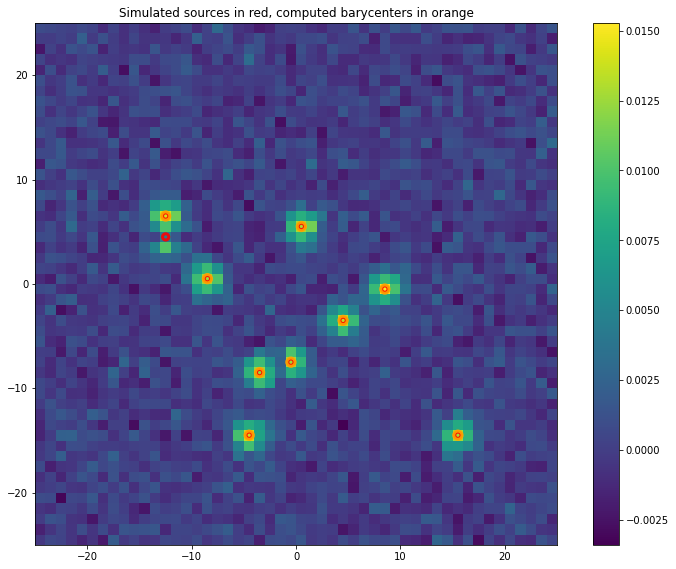

,dec[deg],ra[deg],horizontal coor,vertical coor,vertical center,horizontal center,flux [K],flux[Jy]
1,88.343657,95.194429,25.0,19.0,5.5,0.5,0.034330,0.348193
7,88.290245,217.874984,29.0,28.0,-3.5,4.5,0.060495,0.613573
8,87.746169,273.814075,24.0,32.0,-7.5,-0.5,0.067882,0.688495
4,87.447282,3.366461,16.0,24.0,0.5,-8.5,0.056035,0.568337
3,87.447282,183.366461,33.0,25.0,-0.5,8.5,0.075380,0.764537
6,87.244410,292.380135,21.0,33.0,-8.5,-3.5,0.030796,0.312351
5,85.780941,27.474432,12.0,18.0,6.5,-12.5,0.009381,0.095150
0,85.454890,287.241459,20.0,39.0,-14.5,-4.5,0.004635,0.047014
2,83.658526,223.090848,40.0,39.0,-14.5,15.5,0.080419,0.815654


In [ ]:


barycenter_center=CircularAperture(bar_center, r=0.4)
barycenter_upper=CircularAperture(np.transpose((barycenter_list[:,1],barycenter_list[:,0])), r=0.4)

plt.figure(figsize=[12.8, 9.6])

plt.title('Simulated sources in red, computed barycenters in orange')
plt.imshow(rectmap,extent=(-np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2, -np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2))
plt.colorbar()    
simulated_src_center.plot(color='red', lw=3, alpha=0.9)
barycenter_center.plot(color='orange', lw=3, alpha=0.9)

plt.show(block=False)

detection_catalog=np.column_stack((barycenter_list_world[:,1],barycenter_list_world[:,0],barycenter_list[:,1],barycenter_list[:,0],bar_center[:,1],bar_center[:,0],flux_list[0],flux_list[1]))
detection_dataframe=pd.DataFrame(detection_catalog,columns=['dec[deg]','ra[deg]','horizontal coor','vertical coor','vertical center','horizontal center','flux [K]','flux[Jy]'])
sorter=np.flip(np.argsort(detection_dataframe['dec[deg]']))
sorted_detection_dataframe = detection_dataframe.iloc[sorter]

sorted_detection_dataframe




    




#Source finder's Object oriented version

## src_finder.py class code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pandas as pd
import create_map
import global_bg_estimation
import detection_kernels
import sort_signal_to_noise
import hierarchical_merging
import compute_barycenters
import ploting_test
import compute_flux
import pixel2world
import convert_map_index
import convolution_maps
import detection_criteria
import cross_matching
import sys




class src_finder:

    '''

        This class take a map, and other additional attributes (4 or 5 in total) to create an instance of the src finder algorithm

        Attributes
        -----------
        use : str
              write 'python' if the input is a map is a simple numpy made with python
              write 'jskymap' if the map is puted in a FITS file and result from the map-making process, an additional argument should added the file_name
       
        fits_filename : str
                        FITS file name

        map_size : int
                   the length in pixels of a single side of the square map

        map_resolution : int
                         map resolution in arcminutes

        projection_center : tuple
                            (longitude, latitude) in degrees of the center of projection
                           
        detection_kernels_size : list
                                 [central kernel size, intermediate kernel size, peripherical kernel size] in pixels
        
        n : int
            threshold of detection in the condition : <central_kernel>   >   bg + n * std_bg

        aperture : list
                   [..,..] to be corrected

        Return
        --------
        ????????
                                 
    '''


    def __init__(self,use,detection_kernels_size,n,aperture,fits_filename,map_size,map_resolution,projection_center,noise,src_number,src_size,src_std,flux,freq,matching_aperture,max_distance):

        self.use = use
        self.detection_kernels_size = detection_kernels_size
        self.n = n
        self.aperture = aperture
        self.map_size = map_size
        self.map_resolution = map_resolution
        self.projection_center = projection_center
        self.noise = noise
        self.src_number = src_number
        self.src_size = src_size
        self.src_std = src_std
        self.flux = flux
        self.freq = freq
        self.matching_aperture = matching_aperture
        self.max_distance = max_distance
            
        if self.use == 'python':
            self.simulation=create_map.create_map(self.map_size,self.src_number,self.src_size,self.src_std,self.flux,self.noise,self.freq,self.map_resolution,self.projection_center)
            self.rectmap=self.simulation[0]
            self.simulation_dataframe=self.simulation[1]

        if self.use == 'JSkyMap':
            #create the instance, read a fits file, transform a spherical map into bumpy, extract a gnomonic projection.
            self.fits_filename = fits_filename
            self.spherical_map=hp.read_map(self.fits_filename,dtype=None)
            self.rectmap=hp.gnomview(self.spherical_map,rot=[self.projection_center[0],self.projection_center[1]],reso=self.map_resolution,xsize=self.map_size,ysize=self.map_size,return_projected_map=True,no_plot=True)
            #??????????????????? here you should import the txt file  catalog in case of jskymap
    





        #global background estimation
        #------------------------------
        #This step use the function global_bg_bestimation from the file global_bg_estimation.py
        '''
        This function take a map and give its background parameters ( med?? clipping??)

        parameters
        -----------
        map : 2D numpy array

        Return
        -------
        statistics : tuple
                    (map_median,map_std)
        '''   
        self.global_stat = global_bg_estimation.global_bg_estimation(self.rectmap)





  
        # Creating the three detection kernels
        #------------------------------------------
        #This step use the function create_kernels from the file detection_kernels.py
        ''' 
        This function take the size of kernels and give the kernels 

        parameters
        -------------
        detection_kernels_size: tuple   (int, int, int)
                                (size of central kernel, size of intermediate kernel, size of peripherical kernel) 
                                           
        Return
        -------
        kernels: tuple (2D NumPy array, 2D NumPy array, 2D NumPy array)
                           (central_kernel, intermediate_kernel, peripherical_kernel)                 
        '''

        self.kernels = detection_kernels.create_kernels(self.detection_kernels_size)






        #Compute convolution maps
        #--------------------------------
        #This step use the function conv_maps from the file convolution_maps.py

        ''' This function take three kernels, build additional two kernels, and then give convolution maps of 5 kernels
    
        parameters
        ------------
        kernels: tuple (2D NumPy array, 2D NumPy array, 2D NumPy array)
                       (central kernel, intermediate kernel, peripherical kernel)
             
        detection_kernels_size: tuple
                               (size of central kernel, size of intermediate kernel, size of peripherical kernel)

        rectmap: 2D NumPy array
                 the main map

        Return
        --------
        Convolution maps: tuple  (2D NumPy array, 2D NumPy array, 2D NumPy array, 2D NumPy array, 2D NumPy array)
                                 (Convolution with central kernel map, Convolution with intermediate kernel map, Convolution with peripherical kernel map (local average), Convolution with peripherical kernel map (local median), Convolution with peripherical kernel map (local std))                       
        '''

        self.conv_maps=convolution_maps.create_conv_maps(self.kernels,self.detection_kernels_size,self.rectmap)







        #Execute the detection
        #-----------------------------
        #This step use the function detection from the file detection_criteria.py

        ''' This function take convolution maps, manipulate them within detection criteria, 
        and return list of pixels that belong to potential sources and their amplitude. It is sorted by the S/N ratio

        parameters:
        -------------
        conv_maps: tuple (2D NumPy array, 2D NumPy array, 2D NumPy array, 2D NumPy array, 2D NumPy array)
                         (Convolution with central kernel map, Convolution with intermediate kernel map, Convolution with peripherical kernel map (local average), Convolution with peripherical kernel map (local median), Convolution with peripherical kernel map (local std))                       
  
        n: int
           The detection threshold 
       
        Return:
        -------  
        sorted_raw_detection: dataframe 
                              all pixels verifying detection criteria sorted by their decreasing S/N ratio
        '''
        
        self.sorted_raw_detection = detection_criteria.detection(self.conv_maps,self.n,self.rectmap,self.global_stat)





        # resolving the no detection case
       # if len(self.detected_src_coor_upper_pixcorner[0])!=0:
        #    self.no_detection=False
        #else:
         #   self.no_detection=True
            

            




        #clustering pixels into sources
        #-------------------------------
        #This step use the function merging from the file hierarchical_merging.py

        ''' This function take an aperture, and the dataframe of all detections'pixels and give a list where each element represent itself a list of indexes contributing to a single sources

        parameters:
        -------------
        aperture: tuple (float,float)
                  (3,2.5)  
        sorted_raw_detection: dataframe 
                              all pixels verifying detection criteria sorted by their decreasing S/N ratio
       
        Return:
        -------  
        all_agglomerations_index: list
                                  a list where each element represent itself a list of indexes contributing to a single sources
        '''

        self.all_agglomerations_index=hierarchical_merging.merging(self.aperture,self.sorted_raw_detection)






        #compute barycenters
        #----------------------
        # This step use the function compute_barycenters from the file compute_barycenters.py

        ''' This function take the main dataframe and the list of pixels goups, and compute a list of barycenters 

        parameters:
        -------------
        sorted_raw_detection: dataframe 
                              all pixels verifying detection criteria sorted by their decreasing S/N ratio
       
        all_agglomerations_index: list
                                  a list where each element represent itself a list of indexes contributing to a single sources

        Return:
        -------   
        barycenter_list:   tuples list     (2 x source number) 
                          each line present (vertical coor, horizontal coor)                 
        '''

        self.barycenter_list = compute_barycenters.compute_barycenters(self.sorted_raw_detection,self.all_agglomerations_index)


        #compute fluxes
        #------------------
        #This step use the function compute_flux from the file compute_flux.py

        ''' This function take the the convolution maps, the kernels size, the list of barycenters and the frequency, to compute a list of fluxes density in Kelvin and in Jansky
    
        parameters:
        -------------

        detection_kernels_size: tuple
                                (size of central kernel, size of intermediate kernel, size of peripherical kernel)

        barycenter_list:   tuples list     (2 x source number) 
                          each line present (vertical coor, horizontal coor) 
                       
        conv_maps: tuple
                  (avg central map (ndarray), avg intermediate map (ndarray), avg peripherical map (ndarray), median peripherical map (ndarray), std peripherical map (ndarray))
                                      
        freq: float
              the frequency of signal in hertz


        Return:
        -------   
       flux_list:   tuples    (list,list) 
                       list of fluxes in kelvin and in Jansky                
        '''

        self.flux_list=compute_flux.compute_flux(self.detection_kernels_size, self.barycenter_list, self.conv_maps, self.rectmap, self.freq)

        

        #compute barycenter coordinates if the centre of the imgae is the origin
        self.bar_center=convert_map_index.convert_upper_to_center([self.barycenter_list[:,0],self.barycenter_list[:,1]],np.shape(self.rectmap)[0],len(self.barycenter_list[:,0]))[4]


        #compute the world coordinate of barycenters
        self.barycenter_list_world=pixel2world.pixel2world(self.projection_center,self.map_resolution,self.bar_center)

        #set up a final detection dataframe
        detection_catalog=np.column_stack((self.barycenter_list_world[:,0],self.barycenter_list_world[:,1],self.barycenter_list[:,1],self.barycenter_list[:,0],self.bar_center[:,1],self.bar_center[:,0],self.flux_list[0],self.flux_list[1]))
        detection_dataframe=pd.DataFrame(detection_catalog,columns=['ra[deg]','dec[deg]','horizontal coor','vertical coor','vertical center','horizontal center','flux [K]','flux[Jy]'])
        sorter=np.flip(np.argsort(detection_dataframe['dec[deg]']))
        self.sorted_detection_dataframe = detection_dataframe.iloc[sorter]

        #matching the two catalogs
        self.matching_results = cross_matching.cross_matching(self.sorted_detection_dataframe[['ra[deg]', 'dec[deg]', 'flux[Jy]']], self.simulation[1][['ra[deg]', 'dec[deg]', 'flux[Jy]']],self.matching_aperture,self.max_distance)

        #compute efficiency
        self.efficiency = len(self.matching_results[0])/len(self.simulation[1])

        #compute spurious detection
        self.spurious_detection = ( len(self.sorted_detection_dataframe) - len(self.matching_results[0]) )/len(self.sorted_detection_dataframe[1])



In [ ]:

    def plot(self):
        ploting_test.ploting_test(self.rectmap,self.coor_center,self.bar_center,self.simulated_coor_center)



IndentationError: ignored

##Applying the class



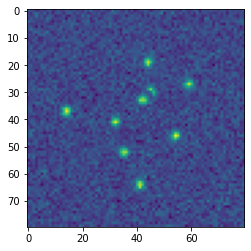

,ra[deg],dec[deg],vertical coor[pixel],horizontal coor[pixel],vertical center,horizontal center,flux [K],flux[Jy]
9,111.037511,87.911667,33.0,42.0,2.5,6.5,0.098595,1.0
2,348.690068,87.706667,41.0,32.0,-7.5,-1.5,0.098595,1.0
8,120.068583,86.710444,30.0,45.0,5.5,9.5,0.098595,1.0
7,289.798876,86.020811,52.0,35.0,-4.5,-12.5,0.098595,1.0
3,204.145542,85.243880,46.0,54.0,14.5,-6.5,0.098595,1.0
1,102.380757,83.728737,19.0,44.0,4.5,20.5,0.098595,1.0
6,147.339087,83.085030,27.0,59.0,19.5,12.5,0.098595,1.0
5,266.496468,82.676385,64.0,41.0,1.5,-24.5,0.098595,1.0
0,266.496468,82.676385,64.0,41.0,1.5,-24.5,0.098595,1.0
4,5.599339,82.358947,37.0,14.0,-25.5,2.5,0.098595,1.0


,ra[deg],dec[deg],horizontal coor,vertical coor,vertical center,horizontal center,flux [K],flux[Jy]
2,356.185925,87.746169,32.0,40.0,-0.5,-7.5,0.063583,0.644889
7,108.434949,87.629645,42.0,32.0,7.5,2.5,0.080225,0.813684
8,117.645975,86.448574,45.0,29.0,10.5,5.5,0.001042,0.010565
4,289.798876,86.020811,35.0,52.0,-12.5,-4.5,-0.009285,-0.094172
0,204.145542,85.243880,54.0,46.0,-6.5,14.5,-0.001630,-0.016535
5,102.380757,83.728737,44.0,19.0,20.5,4.5,0.002997,0.030398
3,145.954063,83.332132,58.0,27.0,12.5,18.5,0.005427,0.055046
11,268.781125,82.983688,40.0,63.0,-23.5,0.5,-0.000432,-0.004382
6,266.496468,82.676385,41.0,64.0,-24.5,1.5,0.005799,0.058819
1,5.599339,82.358947,14.0,37.0,2.5,-25.5,-0.005465,-0.055432


,idx src from det,ra1[deg],dec1[deg],idx src from sim,ra2[deg],dec2[deg],offset
0,7,108.434949,87.629645,9,111.037511,87.911667,0.299571


,idx src from det,ra1[deg],dec1[deg]
0,2,356.185925,87.746169
1,2,356.185925,87.746169
2,2,356.185925,87.746169
3,7,108.434949,87.629645
4,7,108.434949,87.629645
5,8,117.645975,86.448574
6,8,117.645975,86.448574
7,8,117.645975,86.448574
8,8,117.645975,86.448574
9,8,117.645975,86.448574


0.1 1.3


In [ ]:
import importlib
importlib.reload(src_finder)


#create an instance: maps simulated with python
a=src_finder.src_finder(use='python',detection_kernels_size=(3,5,7),n=1,aperture=(3,3),fits_filename='',map_size=80,map_resolution=18,projection_center=(180,90),noise=0.001,src_number=10,src_size=7,src_std=1.2,flux=1,freq=1300*10**6, matching_aperture=1.5 , max_distance=0.8)

#the map
plt.figure()
plt.imshow(a.rectmap)
plt.show()

#the simulation dataframe
display(a.simulation[1])

#the detection dataframe
display(a.sorted_detection_dataframe)

display(a.matching_results[0])

display(a.matching_results[1])

print(a.efficiency,a.spurious_detection)



#Post processing

In [ ]:

import numpy as np
import cross_matching
import importlib
importlib.reload(cross_matching)
importlib.reload(src_finder)



class matcher:

    '''
    This class use the src_finder class located in the file src_finder.py to create a set of images/instance having various values for the following parameters: redshift/frequency, instruments noise std, n, sources flux, and iteration
    All these instance have a simulation data frame and a detection dataframe. For each map the class compute efficiency, spurious detection, and compare detected and simulated fluxes.
    At the end it gives a set of detection's characterization curves

    Attributes
    -----------
    use : str
    write 'python' if the input is a map is a simple numpy made with python
    write 'jskymap' if the map is puted in a FITS file and result from the map-making process, an additional argument should added the file_name

    Return
    --------
    ????????                      
    '''

    def __init__(self, use, detection_kernels_size, aperture, freq_list, noise_list, flux_list, n_list, iteration_number, fits_filename, map_size, map_resolution, projection_center, src_number, src_size, src_std, matching_aperture , max_distance):



        self.use = use
        self.detection_kernels_size = detection_kernels_size
        self.n_list = n_list
        self.aperture = aperture
        self.map_size = map_size
        self.map_resolution = map_resolution
        self.projection_center = projection_center
        self.noise_list = noise_list
        self.src_number = src_number
        self.src_size = src_size
        self.src_std = src_std
        self.flux_list = flux_list
        self.freq_list = freq_list
        self.iteration_number = iteration_number
        self.matching_aperture = matching_aperture
        self.max_distance = max_distance
        self.fits_filename = fits_filename


        #set up a skeleton of the data structure, we create an empty nestled NumPy array to fill it with images
        self.maps_array=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list),self.iteration_number),dtype=tuple)#dtype=src_finder.src_finder)

        #fill the empty structure with maps


        for i in range(0,len(self.freq_list)):
            for j in range(0,len(self.noise_list)):
                for k in range(0,len(self.n_list)):
                    for l in range(0,len(self.flux_list)):
                        for m in range(0,self.iteration_number):
                            
                            #assigning a map to each cell of the empty nestled array
                            map=src_finder.src_finder(use = self.use, detection_kernels_size = self.detection_kernels_size, n = self.n_list[k], aperture = self.aperture, fits_filename = self.fits_filename, map_size = self.map_size, map_resolution = self.map_resolution, projection_center = self.projection_center, noise = self.noise_list[j], src_number = self.src_number, src_size = self.src_size, src_std = self.src_std, flux = self.flux_list[l], freq = self.freq_list[i], matching_aperture = self.matching_aperture, max_distance = self.max_distance) 
                            self.maps_array[i][j][k][l][m] = map
                            


b=matcher(use='python', detection_kernels_size = (3,5,7), aperture = (3,3), freq_list = (1300*10**6,1420*10**6), noise_list = (0.001, 0.005), flux_list = np.arange(2,5,1), n_list = (1,2), iteration_number=3, fits_filename='', map_size = 40, map_resolution = 18, projection_center = (180,90), src_number = 3, src_size = 7 , src_std=1.2, matching_aperture=1.5 , max_distance=0.8)



/content/Tianlai-M2-Internship-/detection_criteria.py:30: RuntimeWarning: divide by zero encountered in true_divide
  signal_to_noise = signal/local_bg_std


In [ ]:
#post_processing_dataframe.py


maj_dim = 1
for dim in b.maps_array.shape:
    maj_dim = maj_dim*dim
new_dims=maj_dim
maps_data = b.maps_array.reshape(new_dims)


#create the indexes
indexes = pd.MultiIndex.from_product([b.freq_list, b.noise_list, b.n_list, b.flux_list, np.arange(0,b.iteration_number)])

 #setting the data frame
maps_dataframe = pd.DataFrame(maps_data, index = indexes, columns=['object'])



#Extract efficiency and spurious detection columns from the object column
def extract_object_parameter(object_column):

    object_column=np.array(object_column)

    efficiency_column=np.zeros(len(object_column)) 
    spurious_detection_column=np.zeros(len(object_column)) 

    for i in range(0,len(object_column)):
      efficiency_column[i]=object_column[i].efficiency
      spurious_detection_column[i]=object_column[i].spurious_detection

    return (efficiency_column, spurious_detection_column)

parameter_columns=extract_object_parameter(maps_dataframe['object'])


maps_dataframe = maps_dataframe.assign(efficiency = parameter_columns[0])
maps_dataframe = maps_dataframe.assign(spurious = parameter_columns[1])



In [ ]:





#reshaping
#maj_dim = 1
#for dim in b.maps_array.shape[:-1]:
#    maj_dim = maj_dim*dim
#new_dims = (maj_dim, b.maps_array.shape[-1])
#maps_data = b.maps_array.reshape(new_dims)


#reshaping
maj_dim = 1
for dim in b.maps_array.shape:
    maj_dim = maj_dim*dim
new_dims=maj_dim
maps_data = b.maps_array.reshape(new_dims)

#create the multi-index dataframe

 #create an artifical index for computing reasons
#art_idx=[]
#counter=0
#for i in range(0,new_dims):
#  suffix=int(i/b.iteration_number)
#  for j in range(0,len(b.flux_list)):
#      art_idx.append('G'+str(suffix)+'-'+str(b.flux_list[j]))
#art_idx=np.unique(np.array(art_idx))    

art_idx=np.zeros(new_dims)
for i in range(0,new_dims):
  art_idx[i]=int(i/b.iteration_number)

 #create the indexes
indexes = pd.MultiIndex.from_product([b.freq_list, b.noise_list, b.n_list, b.flux_list, np.arange(0,b.iteration_number)])

 #setting the data frame
maps_dataframe = pd.DataFrame(maps_data, index = indexes, columns=['object'])



#Extract efficiency and spurious detection columns from the object column
def extract_object_parameter(object_column):

    object_column=np.array(object_column)

    efficiency_column=np.zeros(len(object_column)) 
    spurious_detection_column=np.zeros(len(object_column)) 

    for i in range(0,len(object_column)):
      efficiency_column[i]=object_column[i].efficiency
      spurious_detection_column[i]=object_column[i].spurious_detection

    return (efficiency_column, spurious_detection_column)

parameter_columns=extract_object_parameter(maps_dataframe['object'])


maps_dataframe = maps_dataframe.assign(efficiency = parameter_columns[0])
maps_dataframe = maps_dataframe.assign(spurious = parameter_columns[1])
#maps_dataframe.index.set_names(names=['freq','noise','n','flux','iteration'],level=[0,1,2,3,4])
display(maps_dataframe)
maps_dataframe_2 = maps_dataframe.set_index(art_idx)
display(maps_dataframe_2)


object  \
1300000000 0.001 1 2 0  <src_finder.src_finder object at 0x7fde55269290>   
                     1  <src_finder.src_finder object at 0x7fde50d96510>   
                     2  <src_finder.src_finder object at 0x7fde50d1d6d0>   
                   3 0  <src_finder.src_finder object at 0x7fde50d96b50>   
                     1  <src_finder.src_finder object at 0x7fde50d2ea90>   
...                                                                  ...   
1420000000 0.005 2 3 1  <src_finder.src_finder object at 0x7fde50b3aed0>   
                     2  <src_finder.src_finder object at 0x7fde50b3a8d0>   
                   4 0  <src_finder.src_finder object at 0x7fde50b52f10>   
                     1  <src_finder.src_finder object at 0x7fde50b52550>   
                     2  <src_finder.src_finder object at 0x7fde50ae0e10>   

                        efficiency  spurious  
1300000000 0.001 1 2 0    0.666667  0.000000  
                     1    1.000000  0.000000  
                     2    0.333333  0.666667  
                   3 0    1.000000 -0.500000  
                     1    0.333333  0.500000  
...                            ...       ...  
1420000000 0.005 2 3 1    0.333333  0.666667  
                     2    0.000000  1.000000  
                   4 0    0.000000  1.000000  
                     1    0.000000  1.000000  
                     2    0.000000  1.000000  

[72 rows x 3 columns]

,object,efficiency,spurious
0.0,<src_finder.src_finder object at 0x7fde55269290>,0.666667,0.000000
0.0,<src_finder.src_finder object at 0x7fde50d96510>,1.000000,0.000000
0.0,<src_finder.src_finder object at 0x7fde50d1d6d0>,0.333333,0.666667
1.0,<src_finder.src_finder object at 0x7fde50d96b50>,1.000000,-0.500000
1.0,<src_finder.src_finder object at 0x7fde50d2ea90>,0.333333,0.500000
...,...,...,...
22.0,<src_finder.src_finder object at 0x7fde50b3aed0>,0.333333,0.666667
22.0,<src_finder.src_finder object at 0x7fde50b3a8d0>,0.000000,1.000000
23.0,<src_finder.src_finder object at 0x7fde50b52f10>,0.000000,1.000000
23.0,<src_finder.src_finder object at 0x7fde50b52550>,0.000000,1.000000


In [ ]:
maps_dataframe_2.median(level=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:10352: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  name, axis=axis, level=level, skipna=skipna, numeric_only=numeric_only


,efficiency,spurious
0.0,0.666667,0.000000
1.0,0.666667,0.500000
2.0,0.333333,0.500000
3.0,0.333333,0.666667
4.0,0.333333,0.666667
5.0,0.333333,0.666667
6.0,0.000000,1.000000
7.0,0.333333,0.875000
8.0,0.000000,1.000000
9.0,0.000000,1.000000


In [ ]:
r=maps_dataframe.loc[1300000000,0.001,1,3]['efficiency'].median()
display(maps_dataframe)
med=maps_dataframe.median(level=4)


object  \
1300000000 0.001 1 2 0  <src_finder.src_finder object at 0x7fde55269290>   
                     1  <src_finder.src_finder object at 0x7fde50d96510>   
                     2  <src_finder.src_finder object at 0x7fde50d1d6d0>   
                   3 0  <src_finder.src_finder object at 0x7fde50d96b50>   
                     1  <src_finder.src_finder object at 0x7fde50d2ea90>   
...                                                                  ...   
1420000000 0.005 2 3 1  <src_finder.src_finder object at 0x7fde50b3aed0>   
                     2  <src_finder.src_finder object at 0x7fde50b3a8d0>   
                   4 0  <src_finder.src_finder object at 0x7fde50b52f10>   
                     1  <src_finder.src_finder object at 0x7fde50b52550>   
                     2  <src_finder.src_finder object at 0x7fde50ae0e10>   

                        efficiency  spurious  
1300000000 0.001 1 2 0    0.666667  0.000000  
                     1    1.000000  0.000000  
                     2    0.333333  0.666667  
                   3 0    1.000000 -0.500000  
                     1    0.333333  0.500000  
...                            ...       ...  
1420000000 0.005 2 3 1    0.333333  0.666667  
                     2    0.000000  1.000000  
                   4 0    0.000000  1.000000  
                     1    0.000000  1.000000  
                     2    0.000000  1.000000  

[72 rows x 3 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:10352: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  name, axis=axis, level=level, skipna=skipna, numeric_only=numeric_only


,efficiency,spurious
0,0.333333,0.770833
1,0.166667,0.833333
2,0.166667,0.944444


In [ ]:

import numpy as np
import pandas as pd

def angular_dist(ra1,dec1,ra2,dec2):


    ''' This function take world coordinate of two sources and compute the angular distance between them 

    parameters:
    -------------
    ra1: float
        right ascension of the first source [deg]

    dec1: float
        declination of the second source [deg]
               
    ra2: float
        right ascension of the second source [deg]

    dec2: float
        declination of the second source [deg]

    Return:
    -------   
    angular_distance: float [deg]                
    '''  

    #convert inputs into radians
    r1=np.radians(ra1)
    r2=np.radians(ra2)
    d1=np.radians(dec1)
    d2=np.radians(dec2)
  
    #compute angular distance
    a=(np.sin(np.abs(d1-d2)/2))**2
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    d = 2*np.arcsin(np.sqrt(a + b))

    #convert it to degrees
    angular_distance = np.degrees(d)
  
    return angular_distance

def cross_matching(detection_catalog,simulated_catalog,matching_aperture,max_distance):


    ''' This function two sources'catalogs and give a list of matched and no matched sources
        To limit the number of operation, the search for matched sources for each source is performed within the given aperture
        and later on if the separation distance between two sources is smaller than the threshold max distance, we consider a matching case
        Note that catalogs should be sorted by their declination

    parameters:
    -------------
    detection_catalog: dataframe 
                       (ra, dec, flux)
        
    simulated_catalog: dataframe
                       (ra, dec, flux)
               
    matching aperture: float
                       
    max_distance: float

    Return:
    -------   
    matching_results: tuple (dataframe, dataframe)
                       (dataframe of mathced sources, dataframe of no matched sources)
                                   
    '''  

    matches=[]
    no_matches=[]

    idd=detection_catalog.index
    ids=simulated_catalog.index
    for i in idd:
        for j in ids:

            #reduce the search area to a disk of radius matching_aperture around each source

            c1 = detection_catalog['dec[deg]'][i] >= (simulated_catalog['dec[deg]'][j] - matching_aperture) 
            c2 = detection_catalog['dec[deg]'][i] <= (simulated_catalog['dec[deg]'][j] + matching_aperture) 

            if c1 and c2:
                offset = angular_dist(detection_catalog['ra[deg]'][i], detection_catalog['dec[deg]'][i], simulated_catalog['ra[deg]'][j], simulated_catalog['dec[deg]'][j])
            
                #within this disk compute angular distance, and if it is smaller than max_distance, we consider a matching case

                c3 = offset <= max_distance
                c4 = detection_catalog['flux[Jy]'][i] >= 0.7 * simulated_catalog['flux[Jy]'][j]
                c5 = detection_catalog['flux[Jy]'][i] <= 1.3 * simulated_catalog['flux[Jy]'][j]
                if c3 and c4 and c5:

                #create a matching results dataframes  
                    matches.append((i, detection_catalog['ra[deg]'][i], detection_catalog['dec[deg]'][i],j , simulated_catalog['ra[deg]'][j],	simulated_catalog['dec[deg]'][j], offset))
                else:
                    no_matches.append((i, detection_catalog['ra[deg]'][i], detection_catalog['dec[deg]'][i]))
    #set up the output
    matches_dataframe = pd.DataFrame(matches,columns=['idx src from det', 'ra1[deg]', 'dec1[deg]','idx src from sim', 'ra2[deg]', 'dec2[deg]', 'offset'])                 
    no_matches_dataframe = pd.DataFrame(no_matches,columns=['idx src from det', 'ra1[deg]', 'dec1[deg]'])

    return (matches_dataframe, no_matches_dataframe)

In [ ]:

import src_finder
import numpy as np
import cross_matching
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import k2jansky
import math


class post_processing:



    def __init__(self , use , detection_kernels_size , aperture , freq_list , noise_list , flux_list , n_list, iteration_number , fits_filename='' , map_size=80 , map_resolution=18 , projection_center=(90,180) , src_number=10 , src_size=7 , src_std=1.2, matching_aperture=0.5 , max_distance=0.08):


        self.use = use
        self.detection_kernels_size = detection_kernels_size
        self.n_list = n_list
        self.aperture = aperture
        self.map_size = map_size
        self.map_resolution = map_resolution
        self.projection_center = projection_center
        self.noise_list = noise_list
        self.src_number = src_number
        self.src_size = src_size
        self.src_std = src_std
        self.flux_list = flux_list
        self.freq_list = freq_list
        self.iteration_number = iteration_number
        self.matching_aperture = matching_aperture
        self.max_distance = max_distance


        self.maps=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list),self.iteration_number),dtype=tuple)#dtype=src_finder.src_finder)

        self.median_efficiency=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list)))
        self.std_efficiency=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list)))
        self.median_spurious=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list)))
        self.std_spurious=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list)))
        self.efficiency=np.zeros((len(freq_list),len(self.noise_list),len(self.n_list),len(self.flux_list),self.iteration_number))


        s=0
        ss=len(self.freq_list)*len(self.noise_list)*len(self.n_list)*len(self.flux_list)*self.iteration_number

        for i in range(0,len(self.freq_list)):
            for j in range(0,len(self.noise_list)):
                for k in range(0,len(self.n_list)):
                    for l in range(0,len(self.flux_list)):

                        self.efficiency_vector=np.zeros(self.iteration_number)
                        self.spurious_vector=np.zeros(self.iteration_number)

                        for m in range(0,self.iteration_number):
                    
                            s=s+1
                            self.each_map=src_finder.src_finder('python' , [3,5,7] , self.n_list[k] , self.aperture , '' , self.map_size , self.map_resolution , self.projection_center , self.noise_list[j], self.src_number , self.src_size , self.src_std , self.flux_list[l] , self.freq_list[i]) #instantiation of the detector on each map

                            
                            if self.each_map.no_detection==False:
                                self.each_map.create_catalog()
                                self.matching_results=cross_matching.cross_matching(self.each_map.final_catalog,self.each_map.simulated_final_catalog,self.matching_aperture,self.max_distance)
                                self.each_efficiency=len(self.matching_results[0])/len(self.each_map.simulated_final_catalog)
                                self.each_spurious=(len(self.each_map.final_catalog)-len(self.matching_results[0]))/len(self.each_map.final_catalog)
                                print(ss-s)
 
                            if self.each_map.no_detection==True:
                                print('no detection')
                                self.each_efficiency=0
                                self.each_spurious=0

                            self.efficiency[i][j][k][l][m]=self.each_efficiency

                            self.efficiency_vector[m]=self.each_efficiency
                            self.spurious_vector[m]=self.each_spurious
                        
                            self.maps[i][j][k][l][m]=[self.each_map,self.matching_results,self.each_efficiency,self.each_spurious]  # complete data for each map

                        self.median_efficiency[i][j][k][l]=np.median(self.efficiency_vector)
                        self.std_efficiency[i][j][k][l]=np.std(self.efficiency_vector)
                        self.median_spurious[i][j][k][l]=np.median(self.spurious_vector)
                        self.std_spurious[i][j][k][l]=np.std(self.spurious_vector)

       

# plot efficiency/spurious/flux to characterise the algorithm                       
  
        for i in range(0,len(self.freq_list)):
            for j in range(0,len(self.noise_list)):
                fig, ax = plt.subplots(constrained_layout=True)
                for k in range(0,len(self.n_list)):
                    #plt.style.use('seaborn')
                    plt.title('Efficiency as a function of Flux | Freq={}'.format(self.freq_list[i]))
                    x=self.flux_list
                    y=self.median_efficiency[i][j][k]
                    bar=self.std_efficiency[i][j][k]

                    ax.plot(x,y,label='n={}'.format(self.n_list[k]))
                    ax.set_xlabel('Flux density [Jy]')
                    ax.set_ylabel('Efficiency')
                    ax.legend(loc='lower right')
                    ax.grid(True)
                    
                    ax2=ax.twiny()          
                    ax2.set_xlabel('S/N')
                    ax2.set_xticks((1/(2*math.pi*self.src_std**2)) * k2jansky.jansky2k('freq',1300*1000000,16,0,self.flux_list)/self.noise_list[j])
                    ax.errorbar(x,y, yerr=bar, ls='none', fmt='o', elinewidth=1, capsize=1, barsabove=False)
                    

                    ax3=ax.twiny()
                    ax3.spines['top'].set_position(('outward', 40))
                    ax3.set_xticks( (1/(2*math.pi*self.src_std**2)) * k2jansky.jansky2k('freq',1300*1000000,16,0,self.flux_list))
                    ax3.set_xlabel('Amplitude [mK]')

                    plt.show(block=False)

# plot efficiency boxplot
  
        for i in range(0,len(self.freq_list)):
            for j in range(0,len(self.noise_list)):
                fig, ax = plt.subplots(constrained_layout=True)
                for k in range(0,len(self.n_list)):
                    plt.boxplot(np.transpose(self.efficiency[i][j][k]) )
                plt.legend(loc='lower right')
                plt.show(block=False)